Column names: Index(['Employee_ID', 'Age', 'Gender', 'Job_Role', 'Industry',
       'Years_of_Experience', 'Work_Location', 'Hours_Worked_Per_Week',
       'Number_of_Virtual_Meetings', 'Work_Life_Balance_Rating',
       'Stress_Level', 'Mental_Health_Condition',
       'Access_to_Mental_Health_Resources', 'Productivity_Change',
       'Social_Isolation_Rating', 'Satisfaction_with_Remote_Work',
       'Company_Support_for_Remote_Work', 'Physical_Activity', 'Sleep_Quality',
       'Region'],
      dtype='object')

First few rows of the dataset:
  Employee_ID  Age      Gender           Job_Role    Industry  \
0     EMP0001   32  Non-binary                 HR  Healthcare   
1     EMP0002   40      Female     Data Scientist          IT   
2     EMP0003   59  Non-binary  Software Engineer   Education   
3     EMP0004   27        Male  Software Engineer     Finance   
4     EMP0005   49        Male              Sales  Consulting   

   Years_of_Experience Work_Location  Hours_Worked_Per_Week

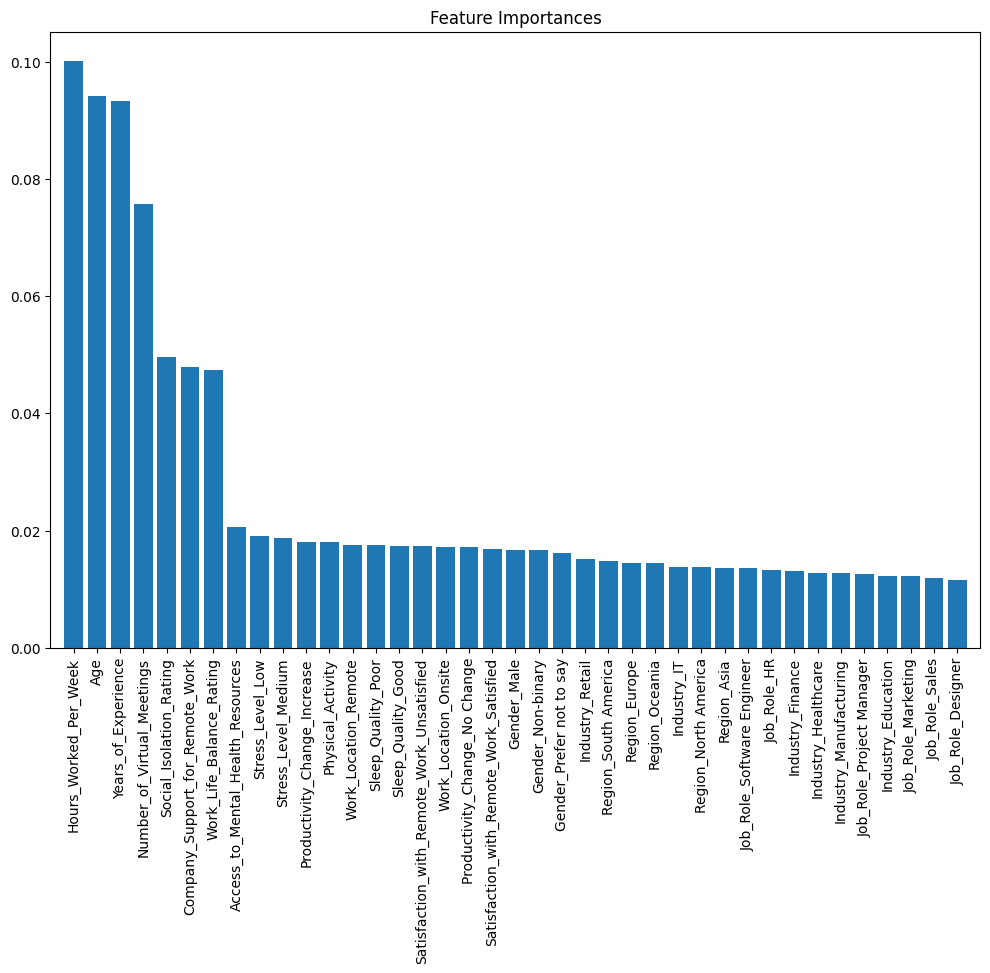

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/kaggle/input/remote-work-and-mental-health/Impact_of_Remote_Work_on_Mental_Health.csv')

# Display column names and first few rows
print("Column names:", df.columns)
print("\nFirst few rows of the dataset:")
print(df.head())

# 1. Handle Missing Values without inplace to avoid warnings
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna(df[column].mode()[0])
    else:
        df[column] = df[column].fillna(df[column].mean())

# 2. Drop unnecessary columns
df = df.drop(columns=['Employee_ID'])

# 3. Encode 'Mental_Health_Condition' as numerical categories for classification
mental_health_mapping = {'None': 0, 'Anxiety': 1, 'Depression': 2}
df['Mental_Health_Condition'] = df['Mental_Health_Condition'].map(mental_health_mapping)

# 4. Check for NaN values in the target variable
if df['Mental_Health_Condition'].isnull().any():
    print("Found NaN values in the target variable. Removing those rows.")
    df = df.dropna(subset=['Mental_Health_Condition'])

# 5. Encode Categorical Columns
categorical_columns = df.select_dtypes(include='object').columns
label_encoders = {}

df_encoded = df.copy()
for col in categorical_columns:
    if df[col].nunique() == 2:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    else:
        df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True)

# 6. Feature Scaling for numerical columns
numerical_columns = df_encoded.select_dtypes(include='number').columns.difference(['Mental_Health_Condition'])
scaler = StandardScaler()
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

# 7. Split the dataset into features (X) and target (y)
X = df_encoded.drop(columns=['Mental_Health_Condition'])  # Drop target column
y = df_encoded['Mental_Health_Condition']  # Target variable

# 8. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 9. Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 10. Make predictions and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Random Forest: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 11. Display feature importance
feature_importances = model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()
